In [1]:
# Activate your environment
import Pkg
Pkg.activate("../KellyEnv")

  Activating project at `c:\Users\Zahnbuerste_HQ\Documents\AA_Studium\Master\05_Masterarbeit\Playground\VS_refactor\KellyEnv`


In [2]:
using UnfoldSim
using Unfold
using StableRNGs
using SequentialSamplingModels
using CairoMakie, UnfoldMakie

In [3]:
include(joinpath(pathof(Unfold),"..","eventhandling.jl"))

copy_eventinfo!

In [4]:
using Statistics
function add_rt_to_events_and_slow_flag(evts, evt_char)
    original_onsets = diff(evts.latency; dims=1)
    original_onsets = vcat(original_onsets, 600)
    evts.rt = original_onsets
    # Add slow_response flag
    mask = evts.event .== evt_char
    # Calculate the median only for the rows where the mask is true
    filtered_rt = evts.rt[mask]  
    med_rt = median(filtered_rt)
    # Initialize slow_response column with false
    evts.slow_response = falses(size(evts.rt))
    # Apply the condition only to the masked rows
    evts.slow_response[mask] .= filtered_rt .> med_rt
    return evts
end

add_rt_to_events_and_slow_flag (generic function with 1 method)

# Setup

In [5]:
rng = StableRNG(12)
dm = 1.2 #1.2; # mean drift rate /sec
ds = .5; #0.5 std of drift rate /sec

# Let's generate a bunch of drift rates and record them:
d = dm .+ ds .* randn(rng, 500,1)
drift_rates_500 = [ [abs(x[1])] for x in eachrow(d)];

In [6]:
fs = 200
Δt = 1/fs; # time step
tEnd = 2 # trial Duration
time_vec = 0:Δt:tEnd; # time base - let's make it a typical stimulus duration
max_length = tEnd/Δt

design_single = SingleSubjectDesign(conditions = Dict(:drift_rate => drift_rates_500, :condition => [1]))
design_seq = SequenceDesign(design_single,"SR")
design_rep = RepeatDesign(design_seq,1)

RepeatDesign{SequenceDesign{SingleSubjectDesign}}
  design: SequenceDesign{SingleSubjectDesign}
  repeat: Int64 1


# Components

In [7]:
kelly_model_parameter = Dict(:drift_rate => 5.5,
    :ramp_down_duration => 0.6,
    :boundary => 0.5,
    :motor_onset => 0.6,
    :post_accumulation_duration => 0.0)

kelly_drift = DriftComponent(max_length,fs,KellyModel,kelly_model_parameter)

lba_parameter = Dict(:ν=>"drift_rate", :A=>0.01, :k=>1.8, :τ=>0.0, :σ=>0)

lba_drift = DriftComponent(max_length,fs,LBA,lba_parameter)
components = Dict('S' => [kelly_drift], 'R' => [deepcopy(lba_drift)])

Dict{Char, Vector{DriftComponent}} with 2 entries:
  'R' => [DriftComponent(400, 200, LBA, Dict{Symbol, Any}(:ν=>"drift_rate", :σ=…
  'S' => [DriftComponent(400, 200, KellyModel, Dict(:ramp_down_duration=>0.6, :…

# Onset

In [8]:
seq_onset = SequenceOnset(
    Dict('S'=>(DriftOnset(), UniformOnset(width=0,offset=-10)),
         #'C'=>DriftOnset(),
         'R'=>UniformOnset(width=0,offset=(tEnd*fs))))

SequenceOnset(Dict{Char, Any}('R' => UniformOnset
  width: Int64 0
  offset: Int64 400
, 'S' => (DriftOnset{UniformOnset}(UniformOnset
  width: Int64 0
  offset: Int64 0
), UniformOnset
  width: Int64 0
  offset: Int64 -10
)))

# Simulation

In [9]:
data, evts = UnfoldSim.simulate(
    rng,
    design_rep,
    components,
    seq_onset,
    NoNoise() 
)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1000×4 DataFrame
  Row │ drift_rate  condition  event  latency 
      │ Array…      Int64      Char   Any     
──────┼───────────────────────────────────────
    1 │ [1.39177]           1  S      401
    2 │ [1.39177]           1  R      565
    3 │ [2.00354]           1  S      965
    4 │ [2.00354]           1  R      1145
    5 │ [1.98519]           1  S      1545
    6 │ [1.98519]           1  R      1708
    7 │ [1.30874]           1  S      2108
    8 │ [1.30874]           1  R      2261
  ⋮   │     ⋮           ⋮        ⋮       ⋮
  994 │ [1.53902]           1  R      282122
  995 │ [1.65029]           1  S      282522
  996 │ [1.65029]           1  R      282683
  997 │ [2.0377]            1  S      283083
  998 │ [2.0377]            1  R      283262
  999 │ [1.26834]           1  S      283662
 1000 │ [1.26834]           1  R      283836
                              985 row

# Plots

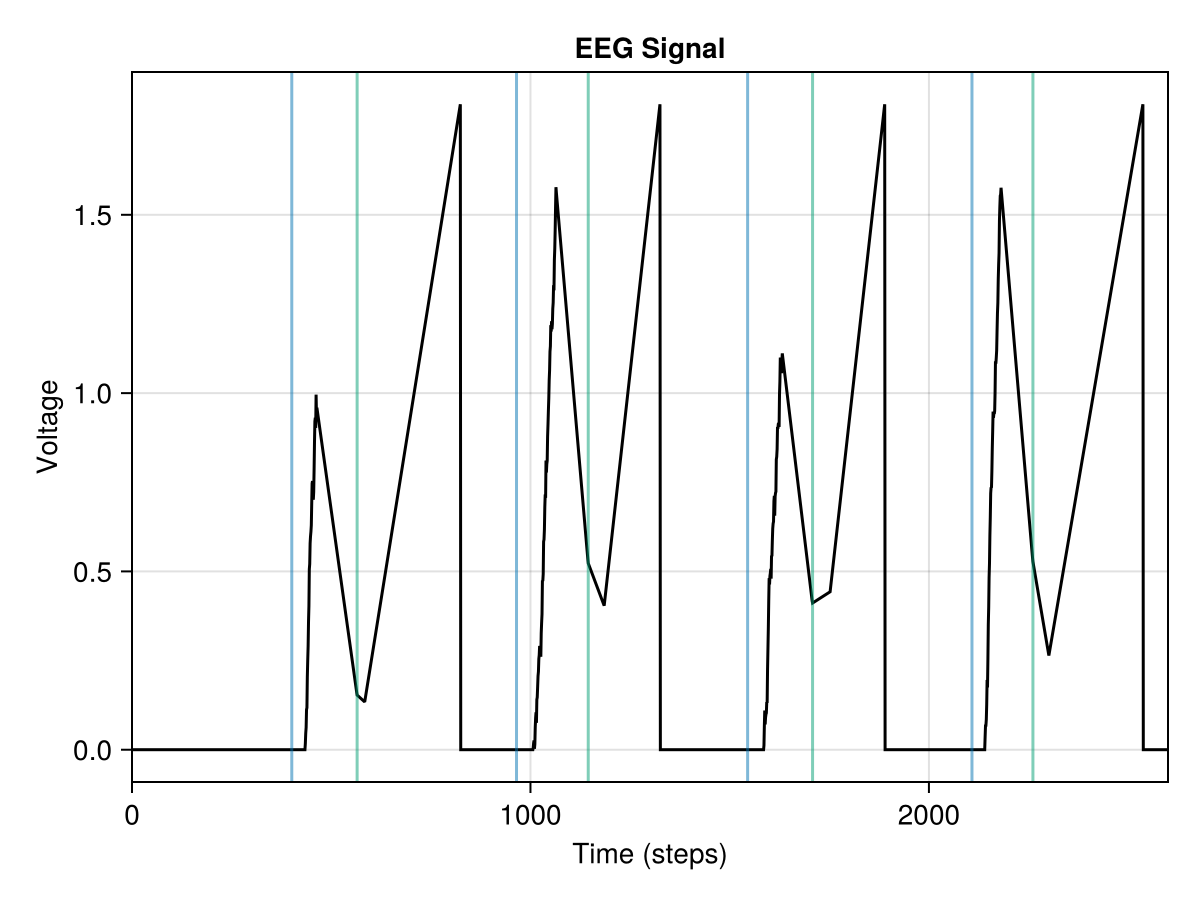

CairoMakie.Screen{IMAGE}


In [10]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time (steps)", ylabel="Voltage", title="EEG Signal")
lines!(data[1:2600], color=(:black, 1))
evts_limited = deepcopy(evts)[1:10, :]
CairoMakie.xlims!(0, 2600)
vlines!(evts_limited.latency[evts_limited.event.=='S'], color = (Makie.wong_colors()[1], 0.5))
#vlines!(evts_limited.latency[evts_limited.event.=='C'], color = (Makie.wong_colors()[2], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='R'], color = (Makie.wong_colors()[3], 0.5))
display(fig)

(isnothing(evts), isnothing(tbl)) = (false, false)


┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19


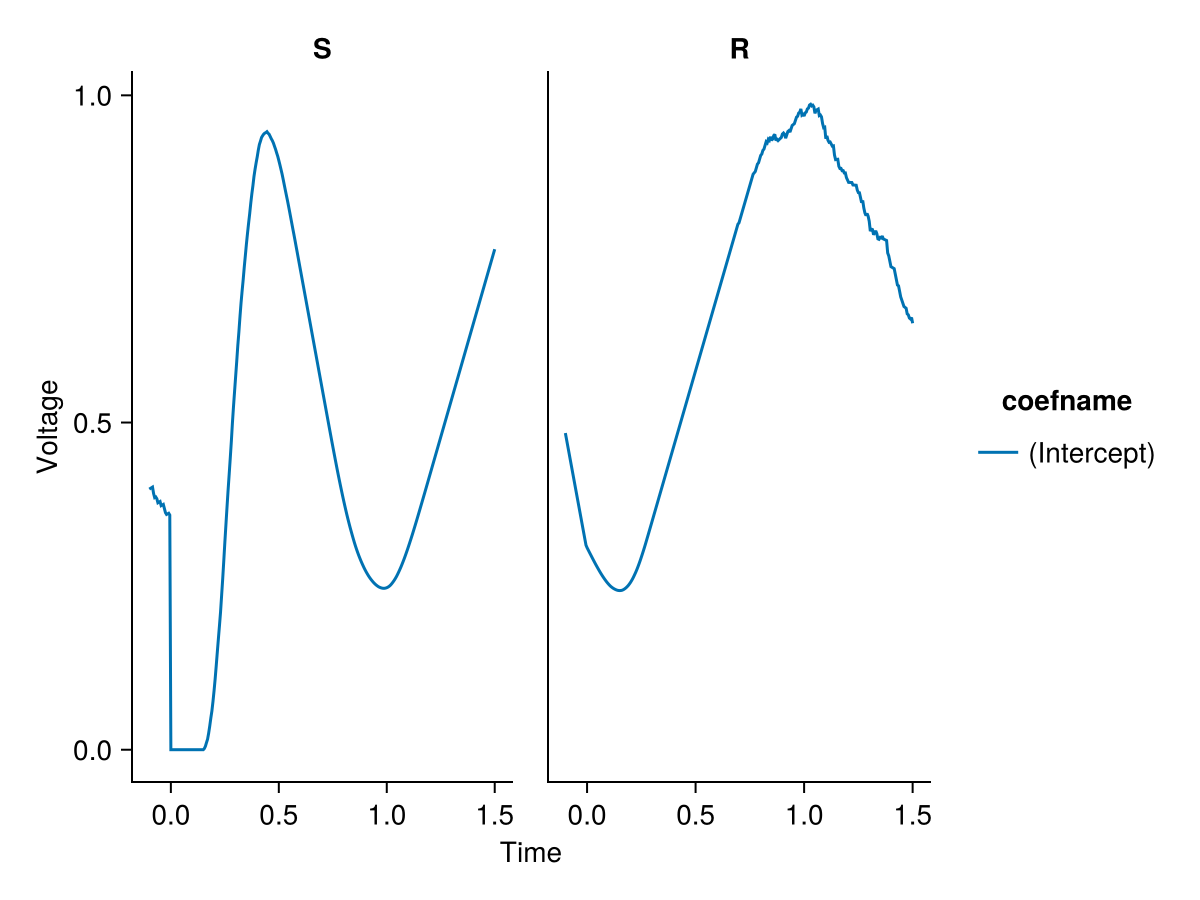

In [18]:
# ## Plot ERP of simulated EEG
evts2 = deepcopy(evts)
evts2.event = string.(evts2.event)
data_epochs, times_epoch = Unfold.epoch(data = data, tbl = evts2, τ = (-0.1, 1.5), sfreq = fs);
f = @formula(0 ~ 1)
m = fit(UnfoldModel, ["S"=>(f,times_epoch),"R"=>(f,times_epoch)], evts2, data_epochs);
results_m = coeftable(m)
#results_m = effects(Dict(:slow_response=>[true,false]),m)
#results_m.slow_response = string.(results_m.slow_response) color=:slow_response
plot_erp(results_m;mapping=(;col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter("S","R")))

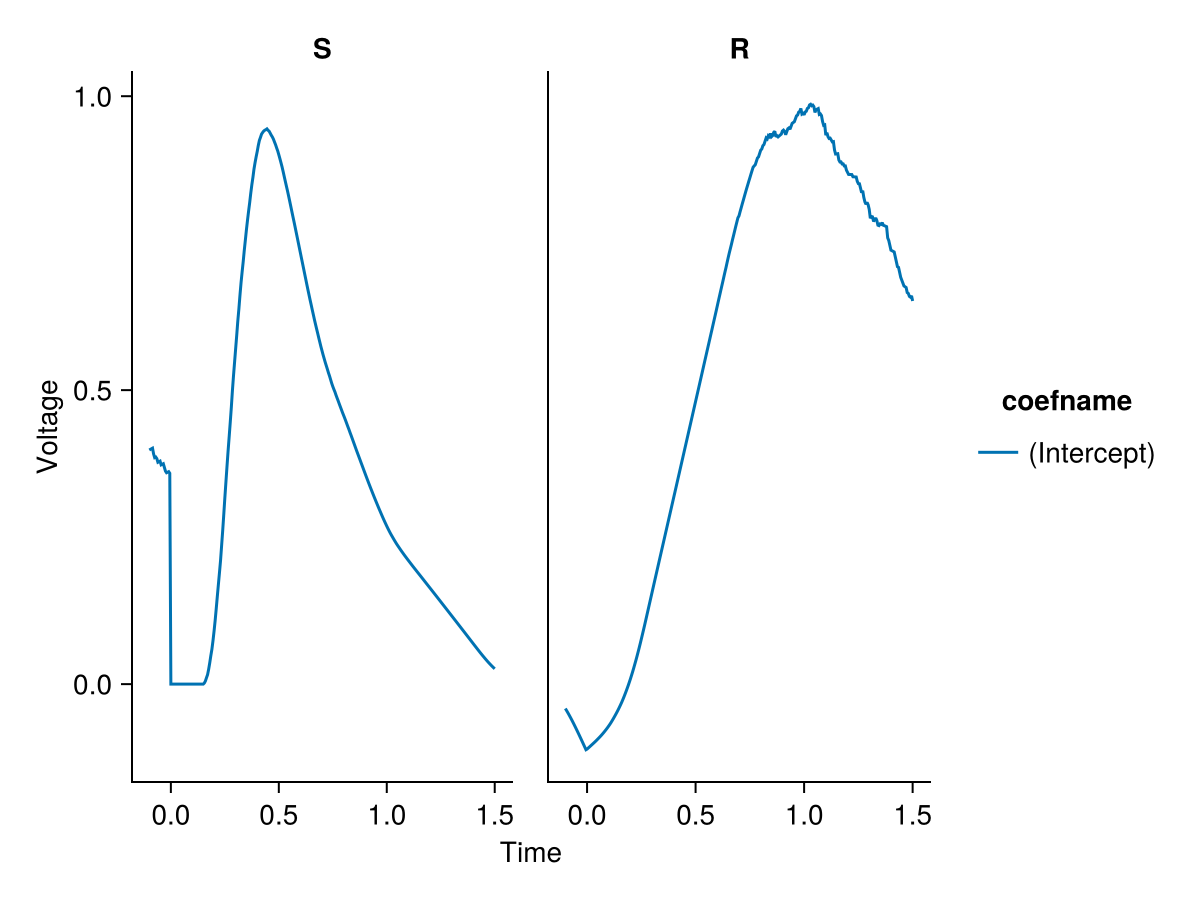

In [17]:
# ## Deconvolution of the overlap
fir_S = firbasis(τ=(-0.1,1.5),sfreq=fs)
fir_R = firbasis(τ=(-0.1,1.5),sfreq=fs)

evts3 = deepcopy(evts2)
evts3.event = string.(evts3.event)
m = fit(UnfoldModel, ["S"=>(f,fir_S),"R"=>(f,fir_R)], evts3, data);
results_m_erp = coeftable(m)
#results_m_erp = effects(Dict(:slow_response=>[true,false]),m)
#results_m_erp.slow_response = string.(results_m_erp.slow_response)color=:slow_response

plot_erp(results_m_erp;mapping=(;col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter("S","R")))

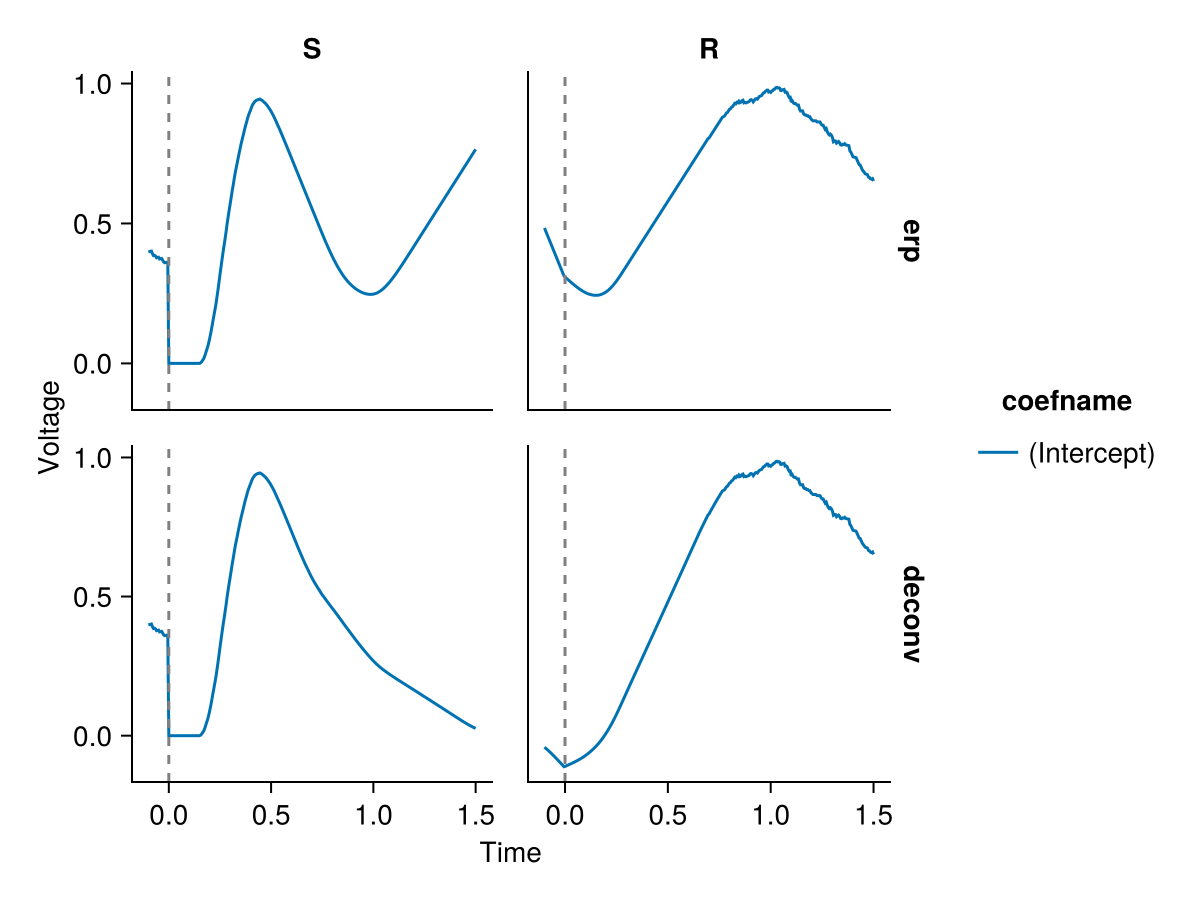

In [19]:
results_m.group .= "erp"
results_m_erp.group .= "deconv"
c = vcat(results_m,results_m_erp)
h = plot_erp(c;mapping=(;col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter(["S","R"]),
            row=:group=>UnfoldMakie.AlgebraOfGraphics.sorter(["erp","deconv"])))
vlines!.(h.content[1:4],[0],linestyle=:dash,color=:gray)
current_figure()